In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [3]:
df = pd.read_hdf('freesolv_with_samples.h5')

In [4]:
from openforcefield.topology import Molecule

In [5]:
inds = list(df.index)


allowed_elements = {1, 6, 8}

cho_freesolv = []
for key in inds:
    offmol = df['offmol'][key]
    if set([a.atomic_number for a in offmol.atoms]).issubset(allowed_elements):
        cho_freesolv.append(key)
print(len(cho_freesolv))

300


In [6]:
np.random.seed(0)
inds = list(cho_freesolv)
np.random.shuffle(inds)
train_inds = inds[::2]
valid_inds = inds[1::2]
len(train_inds), len(valid_inds)

(150, 150)

In [7]:
from openmmtools.constants import kB
from simtk import unit
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

temperature = 300 * unit.kelvin
kT = kB * temperature

# conversion from espaloma energy unit to kT
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

Using backend: pytorch


1052.5821686494048

In [8]:
df['offmol']['mobley_1017962'].partial_charges

Quantity(value=array([-0.09266   , -0.07967   , -0.07829   , -0.07824   , -0.12671   ,
        0.63147002, -0.53658998, -0.44984001,  0.12808   ,  0.03392   ,
        0.03392   ,  0.03392   ,  0.04138   ,  0.04138   ,  0.03957   ,
        0.03957   ,  0.05656   ,  0.05656   ,  0.07839   ,  0.07839   ,
        0.04963   ,  0.04963   ,  0.04963   ]), unit=elementary charge)

In [12]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
df['distance_matrices'] = None

xyz_column = 'xyz'

for key in df.index:
    xyz = (df[xyz_column][key] * unit.nanometer).value_in_unit(DISTANCE_UNIT)
    distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
    distance_matrices = torch.stack(distance_matrices)
    df['distance_matrices'][key] = distance_matrices

In [13]:
df.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system', 'xyz', 'quick_xyz', 'distance_matrices'],
      dtype='object')

In [14]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [15]:
def compute_obc2_energies(
    distance_matrices,
    radii, scales, charges,
    alpha=0.8, beta=0.0, gamma=2.909125
):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges, 
            alpha, beta, gamma,
        )
    return E_s

In [16]:
offmol = df['offmol'][key]

In [17]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

# radii, scales
atom_dim = 2

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, atom_dim), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    graph_model = ValenceModel(node_representation, readouts)
    return graph_model


def predict_obc2_params(offmol, graph_model):
    """output of graph net's atom representation will initially be near zero, just offset by a constant"""
    params = graph_model.forward(offmol)
    radii = params.atoms[:,0] + 2.5
    scales = params.atoms[:,1] + 1
    return radii, scales

In [18]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [19]:
def predict_on_key(key: str, graph_model, batch_size: int = 25, verbose: bool = False) -> float:
    offmol = df['offmol'][key]
    
    radii, scales = predict_obc2_params(offmol, graph_model)
    
    distance_matrices = df['distance_matrices'][key]
    inds = np.random.randint(0, len(distance_matrices), size=batch_size)
    
    charges = torch.tensor(offmol.partial_charges / unit.elementary_charge)
    
    obc2_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    if verbose:
        print(obc2_energies)
    w = obc2_energies * to_kT
    pred_delta_f = one_sided_exp(w)
    
    return pred_delta_f

In [20]:
train_inds

['mobley_6632459',
 'mobley_1502181',
 'mobley_7676709',
 'mobley_7393673',
 'mobley_2197088',
 'mobley_9565165',
 'mobley_5747981',
 'mobley_172879',
 'mobley_8754702',
 'mobley_7375018',
 'mobley_5890803',
 'mobley_3715043',
 'mobley_7017274',
 'mobley_6081058',
 'mobley_7497999',
 'mobley_3053621',
 'mobley_1261349',
 'mobley_7009711',
 'mobley_5467162',
 'mobley_9942801',
 'mobley_7039935',
 'mobley_2859600',
 'mobley_2261979',
 'mobley_7573149',
 'mobley_1244778',
 'mobley_2609604',
 'mobley_5390332',
 'mobley_2295058',
 'mobley_5157661',
 'mobley_9197172',
 'mobley_4035953',
 'mobley_2354112',
 'mobley_9246215',
 'mobley_8118832',
 'mobley_1717215',
 'mobley_4792268',
 'mobley_8809190',
 'mobley_4587267',
 'mobley_1967551',
 'mobley_5917842',
 'mobley_36119',
 'mobley_8573194',
 'mobley_7610437',
 'mobley_6854178',
 'mobley_820789',
 'mobley_9121449',
 'mobley_8785107',
 'mobley_4694328',
 'mobley_3234716',
 'mobley_5627459',
 'mobley_9112978',
 'mobley_3746675',
 'mobley_2577969

In [21]:
from tqdm import tqdm

In [22]:
import matplotlib.pyplot as plt

In [23]:
from openforcefield.topology import Molecule

In [24]:
torch.manual_seed(12345)
np.random.seed(12345)

In [25]:
graph_model = initialize()
learning_rate = 1e-3
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [26]:
keys = train_inds
len(keys)

150

In [27]:
def get_all_preds(keys):
    """TODO: have this (and predict_on_key()) accept an argument that prevents subsampling the configurations"""
    predict_dict = dict()
    for key in keys:
        predict_dict[key] = float(predict_on_key(key, graph_model, 50).detach() * kT / unit.kilocalorie_per_mole)
    return predict_dict

In [28]:
def report_train_and_validation_rmse(predict_dict):
    train_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in train_inds])
    validation_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in valid_inds])
    
    return np.sqrt(np.mean(train_residuals**2)), np.sqrt(np.mean(validation_residuals**2))

In [29]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 15

for t in trange:
    
    # optionally subsample the training set...
    keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        #predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(batch_rmse_in_kcalmol=rmse_in_kcalmol)
    
    n_batches_per_epoch = int(len(train_inds) / n_mols_per_batch)
    
    if t % n_batches_per_epoch == 0:
        epoch = int(t / n_batches_per_epoch)
        p = get_all_preds(cho_freesolv)
        predictions.append(p)
        train_rmse, valid_rmse = report_train_and_validation_rmse(p)
        print(f'training rmse: {train_rmse:.3f}')
        print(f'validation rmse: {valid_rmse:.3f}')
        
        torch.save(graph_model, f'cho_freesolv_epoch={epoch}.pt')

  0%|          | 1/1000 [00:22<6:12:06, 22.35s/it, batch_rmse_in_kcalmol=5.26]

training rmse: 4.699
validation rmse: 3.532


  2%|▏         | 16/1000 [00:47<1:34:12,  5.74s/it, batch_rmse_in_kcalmol=7.06]

training rmse: 3.780
validation rmse: 2.959


  3%|▎         | 31/1000 [01:10<1:30:14,  5.59s/it, batch_rmse_in_kcalmol=3.99]

training rmse: 3.447
validation rmse: 3.073


  5%|▍         | 46/1000 [01:34<1:28:07,  5.54s/it, batch_rmse_in_kcalmol=2.81]

training rmse: 2.560
validation rmse: 2.495


  6%|▌         | 61/1000 [02:00<1:39:37,  6.37s/it, batch_rmse_in_kcalmol=2.23]

training rmse: 2.143
validation rmse: 2.213


  8%|▊         | 76/1000 [02:28<1:43:15,  6.70s/it, batch_rmse_in_kcalmol=3.57]

training rmse: 1.997
validation rmse: 2.033


  9%|▉         | 91/1000 [02:57<1:45:15,  6.95s/it, batch_rmse_in_kcalmol=2.26]

training rmse: 1.766
validation rmse: 1.910


 11%|█         | 106/1000 [03:26<1:43:39,  6.96s/it, batch_rmse_in_kcalmol=1.87]

training rmse: 1.817
validation rmse: 1.949


 12%|█▏        | 121/1000 [03:56<1:42:10,  6.97s/it, batch_rmse_in_kcalmol=1.12]

training rmse: 1.704
validation rmse: 1.869


 14%|█▎        | 136/1000 [04:24<1:36:41,  6.71s/it, batch_rmse_in_kcalmol=1.92]

training rmse: 1.669
validation rmse: 1.828


 15%|█▌        | 151/1000 [04:56<1:50:08,  7.78s/it, batch_rmse_in_kcalmol=1.15]

training rmse: 1.737
validation rmse: 1.879


 17%|█▋        | 166/1000 [05:25<1:30:31,  6.51s/it, batch_rmse_in_kcalmol=1.56]

training rmse: 1.639
validation rmse: 1.831


 18%|█▊        | 181/1000 [05:52<1:28:40,  6.50s/it, batch_rmse_in_kcalmol=1.36]

training rmse: 1.573
validation rmse: 1.742


 20%|█▉        | 196/1000 [06:22<1:38:02,  7.32s/it, batch_rmse_in_kcalmol=2.15]

training rmse: 1.517
validation rmse: 1.716


 21%|██        | 211/1000 [06:58<2:00:11,  9.14s/it, batch_rmse_in_kcalmol=1.09]

training rmse: 1.471
validation rmse: 1.694


 23%|██▎       | 226/1000 [07:44<2:26:55, 11.39s/it, batch_rmse_in_kcalmol=1.84]

training rmse: 1.422
validation rmse: 1.668


 24%|██▍       | 241/1000 [08:22<1:53:06,  8.94s/it, batch_rmse_in_kcalmol=2.21]

training rmse: 1.424
validation rmse: 1.650


 26%|██▌       | 256/1000 [09:07<2:14:07, 10.82s/it, batch_rmse_in_kcalmol=1.74]

training rmse: 1.539
validation rmse: 1.648


 27%|██▋       | 271/1000 [09:43<1:43:47,  8.54s/it, batch_rmse_in_kcalmol=1.58]

training rmse: 1.694
validation rmse: 1.776


 29%|██▊       | 286/1000 [10:16<1:31:33,  7.69s/it, batch_rmse_in_kcalmol=2.53]

training rmse: 1.452
validation rmse: 1.681


 30%|███       | 301/1000 [10:49<1:30:48,  7.79s/it, batch_rmse_in_kcalmol=1.43]

training rmse: 1.270
validation rmse: 1.572


 32%|███▏      | 316/1000 [11:20<1:25:24,  7.49s/it, batch_rmse_in_kcalmol=1.14]

training rmse: 1.061
validation rmse: 1.500


 33%|███▎      | 331/1000 [11:48<1:15:00,  6.73s/it, batch_rmse_in_kcalmol=1.79]

training rmse: 1.062
validation rmse: 1.436


 35%|███▍      | 346/1000 [12:19<1:18:35,  7.21s/it, batch_rmse_in_kcalmol=1.15]

training rmse: 0.963
validation rmse: 1.479


 36%|███▌      | 361/1000 [12:46<1:09:53,  6.56s/it, batch_rmse_in_kcalmol=1.44]

training rmse: 0.946
validation rmse: 1.428


 38%|███▊      | 376/1000 [13:15<1:13:59,  7.12s/it, batch_rmse_in_kcalmol=1.12] 

training rmse: 0.918
validation rmse: 1.465


 39%|███▉      | 391/1000 [13:46<1:14:44,  7.36s/it, batch_rmse_in_kcalmol=0.968]

training rmse: 0.827
validation rmse: 1.411


 41%|████      | 406/1000 [14:16<1:11:44,  7.25s/it, batch_rmse_in_kcalmol=0.917]

training rmse: 0.909
validation rmse: 1.552


 42%|████▏     | 421/1000 [14:47<1:11:03,  7.36s/it, batch_rmse_in_kcalmol=0.584]

training rmse: 0.764
validation rmse: 1.386


 44%|████▎     | 436/1000 [15:17<1:07:21,  7.17s/it, batch_rmse_in_kcalmol=1.03] 

training rmse: 0.742
validation rmse: 1.396


 45%|████▌     | 451/1000 [15:46<1:03:00,  6.89s/it, batch_rmse_in_kcalmol=0.765]

training rmse: 0.754
validation rmse: 1.402


 47%|████▋     | 466/1000 [16:15<1:02:20,  7.01s/it, batch_rmse_in_kcalmol=1.66] 

training rmse: 0.745
validation rmse: 1.440


 48%|████▊     | 481/1000 [16:46<1:03:05,  7.29s/it, batch_rmse_in_kcalmol=1.11] 

training rmse: 0.700
validation rmse: 1.355


 50%|████▉     | 496/1000 [17:14<57:27,  6.84s/it, batch_rmse_in_kcalmol=0.945]  

training rmse: 0.824
validation rmse: 1.414


 51%|█████     | 511/1000 [17:44<56:48,  6.97s/it, batch_rmse_in_kcalmol=1.16] 

training rmse: 0.886
validation rmse: 1.427


 53%|█████▎    | 526/1000 [18:13<56:05,  7.10s/it, batch_rmse_in_kcalmol=1.09] 

training rmse: 0.842
validation rmse: 1.354


 54%|█████▍    | 541/1000 [18:41<51:26,  6.72s/it, batch_rmse_in_kcalmol=1.64] 

training rmse: 1.066
validation rmse: 1.530


 56%|█████▌    | 556/1000 [19:13<56:15,  7.60s/it, batch_rmse_in_kcalmol=0.762]

training rmse: 0.750
validation rmse: 1.336


 57%|█████▋    | 571/1000 [19:40<46:14,  6.47s/it, batch_rmse_in_kcalmol=0.763]

training rmse: 0.670
validation rmse: 1.378


 59%|█████▊    | 586/1000 [20:11<50:51,  7.37s/it, batch_rmse_in_kcalmol=0.795]

training rmse: 0.669
validation rmse: 1.357


 60%|██████    | 601/1000 [20:38<43:52,  6.60s/it, batch_rmse_in_kcalmol=0.586]

training rmse: 0.743
validation rmse: 1.446


 62%|██████▏   | 616/1000 [21:07<44:11,  6.90s/it, batch_rmse_in_kcalmol=1.15] 

training rmse: 0.708
validation rmse: 1.467


 63%|██████▎   | 631/1000 [21:36<43:02,  7.00s/it, batch_rmse_in_kcalmol=0.901]

training rmse: 0.727
validation rmse: 1.312


 65%|██████▍   | 646/1000 [22:05<40:29,  6.86s/it, batch_rmse_in_kcalmol=0.763]

training rmse: 0.695
validation rmse: 1.342


 66%|██████▌   | 661/1000 [22:35<39:50,  7.05s/it, batch_rmse_in_kcalmol=0.888]

training rmse: 0.633
validation rmse: 1.351


 68%|██████▊   | 676/1000 [23:04<37:17,  6.91s/it, batch_rmse_in_kcalmol=0.559]

training rmse: 0.609
validation rmse: 1.337


 69%|██████▉   | 691/1000 [23:34<37:02,  7.19s/it, batch_rmse_in_kcalmol=0.834]

training rmse: 0.694
validation rmse: 1.376


 71%|███████   | 706/1000 [24:03<34:33,  7.05s/it, batch_rmse_in_kcalmol=0.686]

training rmse: 0.625
validation rmse: 1.304


 72%|███████▏  | 721/1000 [24:32<31:32,  6.78s/it, batch_rmse_in_kcalmol=0.575]

training rmse: 0.699
validation rmse: 1.394


 74%|███████▎  | 736/1000 [25:01<30:53,  7.02s/it, batch_rmse_in_kcalmol=1.03] 

training rmse: 0.616
validation rmse: 1.357


 75%|███████▌  | 751/1000 [25:28<26:53,  6.48s/it, batch_rmse_in_kcalmol=0.973]

training rmse: 0.626
validation rmse: 1.387


 77%|███████▋  | 766/1000 [25:57<27:14,  6.98s/it, batch_rmse_in_kcalmol=0.752]

training rmse: 0.599
validation rmse: 1.348


 78%|███████▊  | 781/1000 [26:27<26:04,  7.14s/it, batch_rmse_in_kcalmol=0.593]

training rmse: 0.607
validation rmse: 1.390


 80%|███████▉  | 796/1000 [26:57<24:46,  7.29s/it, batch_rmse_in_kcalmol=0.601]

training rmse: 0.594
validation rmse: 1.407


 81%|████████  | 811/1000 [27:26<21:24,  6.80s/it, batch_rmse_in_kcalmol=0.587]

training rmse: 0.668
validation rmse: 1.356


 83%|████████▎ | 826/1000 [27:55<20:16,  6.99s/it, batch_rmse_in_kcalmol=0.832]

training rmse: 0.616
validation rmse: 1.394


 84%|████████▍ | 841/1000 [28:24<18:29,  6.98s/it, batch_rmse_in_kcalmol=0.593]

training rmse: 0.713
validation rmse: 1.373


 86%|████████▌ | 856/1000 [28:54<17:29,  7.29s/it, batch_rmse_in_kcalmol=0.73] 

training rmse: 0.652
validation rmse: 1.370


 87%|████████▋ | 871/1000 [29:23<14:36,  6.80s/it, batch_rmse_in_kcalmol=1.18] 

training rmse: 0.591
validation rmse: 1.396


 89%|████████▊ | 886/1000 [29:52<13:29,  7.10s/it, batch_rmse_in_kcalmol=0.569]

training rmse: 0.649
validation rmse: 1.327


 90%|█████████ | 901/1000 [30:21<11:42,  7.10s/it, batch_rmse_in_kcalmol=0.888]

training rmse: 0.725
validation rmse: 1.363


 92%|█████████▏| 916/1000 [30:51<10:06,  7.23s/it, batch_rmse_in_kcalmol=0.424]

training rmse: 0.686
validation rmse: 1.429


 93%|█████████▎| 931/1000 [31:20<07:58,  6.94s/it, batch_rmse_in_kcalmol=0.964]

training rmse: 0.591
validation rmse: 1.371


 95%|█████████▍| 946/1000 [31:50<06:31,  7.26s/it, batch_rmse_in_kcalmol=0.718]

training rmse: 0.626
validation rmse: 1.334


 96%|█████████▌| 961/1000 [32:20<04:40,  7.19s/it, batch_rmse_in_kcalmol=0.496]

training rmse: 0.558
validation rmse: 1.398


 98%|█████████▊| 976/1000 [32:50<02:51,  7.16s/it, batch_rmse_in_kcalmol=0.695]

training rmse: 0.620
validation rmse: 1.461


 99%|█████████▉| 991/1000 [33:20<01:02,  6.97s/it, batch_rmse_in_kcalmol=0.655]

training rmse: 0.739
validation rmse: 1.386


100%|██████████| 1000/1000 [33:25<00:00,  2.01s/it, batch_rmse_in_kcalmol=0.563]


In [30]:
def count_params(graph_model):
    n_readout = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.readouts.atoms.state_dict().values()])
    n_rep = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.node_representation.state_dict().values()])
    return n_rep + n_readout

In [31]:
count_params(graph_model)

tensor(115842)

In [32]:
len(predictions)

67

In [33]:
rmses = np.array([report_train_and_validation_rmse(p) for p in predictions])
rmses[:,1].min()

1.3042708426491147

Text(0.5, 1.0, '{C,H,O} mini-freesolv\n(n=300)')

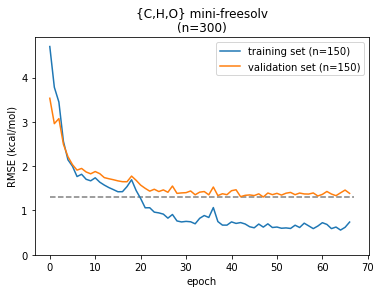

In [34]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0,)
plt.title('{C,H,O} mini-freesolv' + f'\n(n={len(cho_freesolv)})')

Text(0.5, 1.0, '{C,H,O} mini-freesolv\n(n=300)')

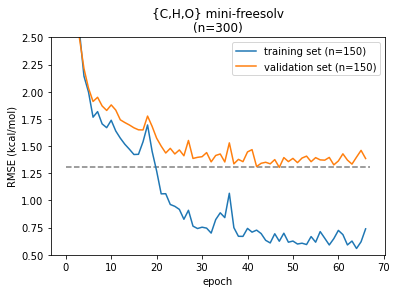

In [35]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0.5,2.5)
plt.title('{C,H,O} mini-freesolv' + f'\n(n={len(cho_freesolv)})')

In [36]:
np.argmin(rmses[:,1]), len(rmses[:,1])

(47, 67)

In [37]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

Text(0.5, 1.0, 'minibatch loss trajectory')

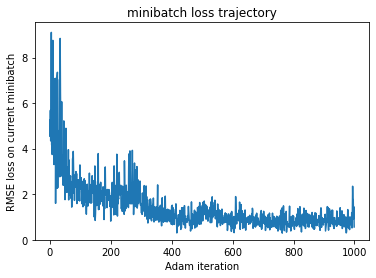

In [38]:
plt.plot(rmse_in_kcalmol)
plt.xlabel('Adam iteration')
plt.ylabel('RMSE loss on current minibatch')
plt.ylim(0,)
plt.title('minibatch loss trajectory')

In [46]:
final_predict_dict = predictions[np.argmin(rmses[:,1])]

In [47]:
float(final_predict_dict[key])

-5.104795630487401

In [48]:
splits = {
    'training': train_inds,
    'validation': valid_inds,
}

In [49]:
def bootstrap_rmse(sq_residuals, n_bootstrap=1000):
    N = len(sq_residuals)
    
    rmses = [np.sqrt(np.mean(sq_residuals[np.random.randint(0, N, N)])) for _ in range(n_bootstrap)]
    return np.array(rmses)

In [50]:
def report_rmse_pm_95ci(sq_residuals: np.ndarray, n_bootstrap=1000) -> str:
    rmse = np.sqrt(np.mean(sq_residuals))
    rmses = bootstrap_rmse(sq_residuals)
    return f'{rmse:.2f} ' + r'$\pm$' + f' {1.96 * np.std(rmses):.2f}'

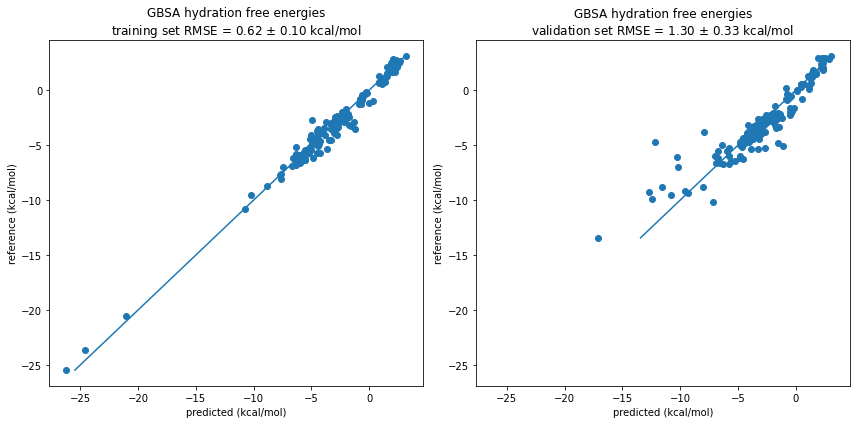

In [51]:
plt.figure(figsize=(12,6))
ax = None

for i, split_name in enumerate(splits):
    split = splits[split_name]
    x = np.array([final_predict_dict[key] for key in split])
    y = np.array([df['experimental value (kcal/mol)'][key] for key in split])
    
    rmse_string = report_rmse_pm_95ci((x - y)**2)
    
    
    ax = plt.subplot(1,2,i+1, sharex=ax, sharey=ax)
    plt.scatter(x, y)
    plt.xlabel('predicted (kcal/mol)')
    plt.ylabel('reference (kcal/mol)')
    plt.plot([min(y), max(y)], [min(y), max(y)])

    plt.title(f'GBSA hydration free energies\n{split_name} set RMSE = {rmse_string} kcal/mol')
plt.tight_layout()

In [52]:
# compare with the RMSE that would be obtained by predicting a constant
np.sqrt(np.mean((y - np.mean(y))**2))

3.1419728381314114

#### TODOs:
* Explicit regularization, rather than early stopping?
* Add bootstrapped rmse bands to train/validation curves, not just to titles of scatterplots
* Do many train/validation splits and report averages / stddevs
* Currently the input is just element identity, one-hot-encoded --> switch to using espaloma's initial atom featurizer?
* Update loss from un-scaled RMSE to something more like a likelihood (incorporating expt error + free-energy-estimator error)
* Do series of mini-freesolvs